In [1]:
import csv,fnmatch,os,json
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
from tqdm import tqdm

%matplotlib inline

data_folder = '/home/thebatou/Documents/Uni_Potsdam/Competitive_Data_Analysis'
print 'Loading data ...'
data = pd.read_csv(os.path.join(data_folder, 'transformed_data.csv'), index_col=0)
print 'Done loading data! {} data were loaded.'.format(data.shape[0])

Loading data ...
Done loading data! 2177 data were loaded.


In [2]:
from sklearn.cross_validation import StratifiedKFold,cross_val_score
from sklearn.linear_model import SGDClassifier
from scipy import interp
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn import metrics

In [4]:
y = data['status'] != 'fully_paid'

In [5]:
data.drop('status',axis=1,inplace=True)
X = data.as_matrix()

1it [00:00,  7.52it/s]

Classification report for classifier DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=0, splitter='best'):
             precision    recall  f1-score   support

      False       1.00      1.00      1.00        66
       True       1.00      1.00      1.00       298

avg / total       1.00      1.00      1.00       364


Confusion matrix:
[[ 66   0]
 [  0 298]]
Classification report for classifier DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=0, splitter='best'):
             precision    recall  f1-score   support

      False       0.98      0.94      0.96        65
       True       0.99      1.00      0.99      


Confusion matrix:
[[ 65   0]
 [  3 294]]
Classification report for classifier DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=0, splitter='best'):
             precision    recall  f1-score   support

      False       1.00      0.95      0.98        65
       True       0.99      1.00      0.99       297

avg / total       0.99      0.99      0.99       362


Confusion matrix:
[[ 62   3]
 [  0 297]]


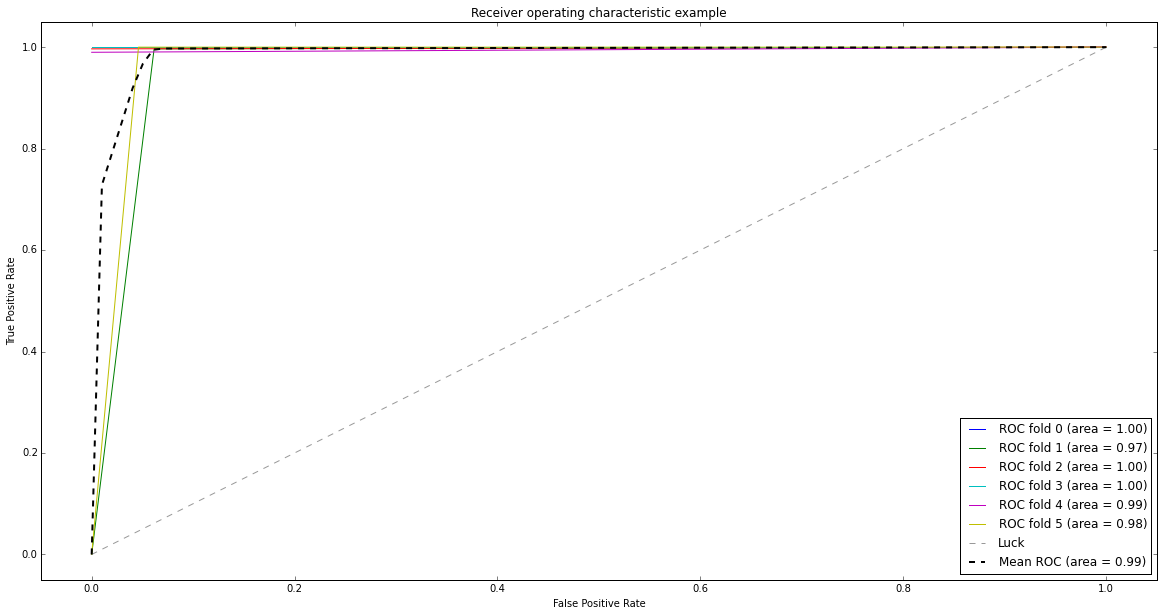

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score

#random_state = np.random.RandomState(0)

cv = StratifiedKFold(y, n_folds=6)
clf = DecisionTreeClassifier(random_state=0)
#clf = svm.SVC(probability=True)

cross_val_score(clf, X, y, cv=10)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
scores = []

plt.figure(figsize=(20,10))

for i, (train, test) in tqdm(enumerate(cv)):
    clf.fit(X[train], y[train])
    scores.append(clf.score(X[test], y[test]))
    y_scores = clf.predict(X[test]) #decision_function(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], y_scores)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    expected = y[test]
    predicted = clf.predict(X[test])

    print("Classification report for classifier %s:\n%s\n"
          % (clf, metrics.classification_report(expected, predicted)))
    print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [18]:
print clf.feature_importances_
print data.columns

[ 0.         0.         0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.         0.8716213
  0.1283787  0.         0.         0.       ]
Index([u'loan_identifier', u'borrower_identifier', u'term', u'purpose',
       u'borrower_rating', u'employment', u'region', u'facebook', u'twitter',
       u'paypal', u'ebay', u'linkedin', u'currency', u'base_currency',
       u'location', u'funded', u'time_between_published_funded',
       u'ratio_requested_funded', u'amount_funded', u'address_lat',
       u'address_lng', u'net_income_cents', u'rates_paid', u'rates_count',
       u'prices', u'portion_average_salary', u'nominal_interest_rate'],
      dtype='object')


Feature ranking:
1. feature 22 (0.234663) 		 rates_paid
2. feature 16 (0.168012) 		 time_between_published_funded
3. feature 15 (0.135973) 		 funded
4. feature 17 (0.096817) 		 ratio_requested_funded
5. feature 2 (0.082454) 		 term
6. feature 23 (0.038778) 		 rates_count
7. feature 0 (0.036841) 		 loan_identifier
8. feature 1 (0.015883) 		 borrower_identifier
9. feature 18 (0.015825) 		 amount_funded
10. feature 13 (0.013756) 		 base_currency
11. feature 4 (0.013434) 		 borrower_rating
12. feature 26 (0.012992) 		 nominal_interest_rate
13. feature 9 (0.012887) 		 paypal
14. feature 12 (0.010813) 		 currency
15. feature 3 (0.010663) 		 purpose
16. feature 19 (0.010614) 		 address_lat
17. feature 20 (0.009997) 		 address_lng
18. feature 21 (0.009417) 		 net_income_cents
19. feature 25 (0.009362) 		 portion_average_salary
20. feature 10 (0.009202) 		 ebay
21. feature 14 (0.008531) 		 location
22. feature 6 (0.008343) 		 region
23. feature 8 (0.008138) 		 twitter
24. feature 24 (0.008106) 

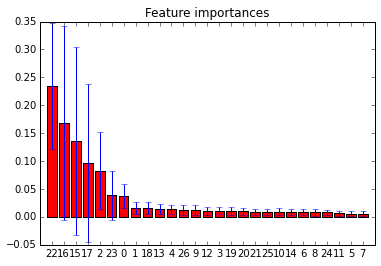

In [23]:
from sklearn.ensemble import ExtraTreesClassifier

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f) \t\t %s" % (f + 1, indices[f], importances[indices[f]], data.columns[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.calibration import CalibratedClassifierCV

X_train, y_train = X[:1300], y[:1300]
X_valid, y_valid = X[1300:1740], y[1300:1740]
X_train_valid, y_train_valid = X[:1740], y[:1740]
X_test, y_test = X[1740:], y[1740:]

# Train uncalibrated random forest classifier on whole train and validation
# data and evaluate on test data
clf = RandomForestClassifier(n_estimators=25)
clf.fit(X_train_valid, y_train_valid)
clf_probs = clf.predict_proba(X_test)
score = log_loss(y_test, clf_probs)

# Train random forest classifier, calibrate on validation data and evaluate
# on test data
clf = RandomForestClassifier(n_estimators=25)
clf.fit(X_train, y_train)
clf_probs = clf.predict_proba(X_test)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(X_valid, y_valid)
sig_clf_probs = sig_clf.predict_proba(X_test)
sig_score = log_loss(y_test, sig_clf_probs)


print("Log-loss of")
print(" * uncalibrated classifier trained on 1300 datapoints: %.3f "
      % score)
print(" * classifier trained on 1300 datapoints and calibrated on "
      "400 datapoint: %.3f" % sig_score)

Log-loss of
 * uncalibrated classifier trained on 1300 datapoints: 0.070 
 * classifier trained on 1300 datapoints and calibrated on 400 datapoint: 0.067
